temp=
 [[ 2  2  2 ...  3  3  3]
 [ 2  2  2 ...  3  3  3]
 [ 5  5  5 ...  4  4  4]
 ...
 [ 1  1  1 ...  1  1  1]
 [ 4  4  4 ...  2  2 12]
 [ 2  2  2 ...  3  3  3]]


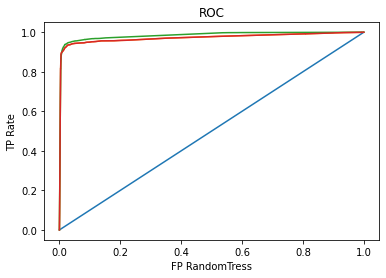

In [35]:
import numpy as np

import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomTreesEmbedding, RandomForestClassifier, GradientBoostingClassifier

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.pipeline import make_pipeline
import lightgbm as lgb


np.random.seed(10)
X, y =make_classification(n_samples=80000, n_features=20)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.5)
X_train, X_train_lr, y_train, y_train_lr = train_test_split(X_train,y_train, test_size=0.5)

#RandomForest + LR
rf = RandomForestClassifier(max_depth=3, n_estimators=10)
rf.fit(X_train, y_train)
rf_enc = OneHotEncoder()
rf_enc.fit(rf.apply(X_train))

rf_lm = LogisticRegression(solver='lbfgs', max_iter=1000)
temp = rf.predict(X_train_lr)
rf_lm.fit(rf_enc.transform(rf.apply(X_train_lr)), y_train_lr)
#LR预测
y_pred_rf_lm = rf_lm.predict_proba(rf_enc.transform(rf.apply(X_test)))[:,1]
fpr_rf_lm, tpr_rf_lm, _ = roc_curve(y_test, y_pred_rf_lm)


#lgb LR
lgb = lgb.LGBMClassifier(n_estimators=10)
lgb.fit(X_train, y_train)

lgb_enc = OneHotEncoder(categories='auto')
lgb_enc.fit(lgb.predict(X_train, pred_leaf=True))


lgb_lm = LogisticRegression(solver='lbfgs', max_iter=1000)
temp = lgb.predict(X_train_lr, pred_leaf= True)
print('temp=\n', temp)

lgb_lm.fit(lgb_enc.transform(lgb.predict(X_train_lr, pred_leaf=True)), y_train_lr)


#LR预测
y_pred_lgb_lm = lgb_lm.predict_proba(lgb_enc.transform(lgb.predict(X_test, pred_leaf=True)))[:,1]
fpr_lgb_lm, tpr_lgb_lm, _ = roc_curve(y_test, y_pred_lgb_lm)



#GBDT

gbdt = GradientBoostingClassifier(max_depth=3, n_estimators=10)
gbdt.fit(X_train, y_train)
gbdt_enc = OneHotEncoder()
gbdt_enc.fit(gbdt.apply(X_train)[:,:,0])

gbdt_lm = LogisticRegression(solver='lbfgs', max_iter=1000)

gbdt_lm.fit(gbdt_enc.transform(gbdt.apply(X_train_lr)[:,:,0]), y_train_lr)
#LR预测
y_pred_gbdt_lm = gbdt_lm.predict_proba(gbdt_enc.transform(gbdt.apply(X_test)[:,:,0]))[:,1]
fpr_gbdt_lm, tpr_gbdt_lm, _ = roc_curve(y_test, y_pred_gbdt_lm)



plt.figure(1)

plt.plot([0,1],[0,1], '')
plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF, LR')
plt.plot(fpr_gbdt_lm, tpr_gbdt_lm, label='GBTD, LR')
plt.plot(fpr_rf_lm, tpr_rf_lm, label='LGB, LR')
plt.xlabel('FP RandomTress')
plt.ylabel('TP Rate')
plt.title('ROC')
plt.show()